In [3]:
import re
from collections import Counter

def tokenize(text):
    """Simple tokenization: lowercase and remove non-alphanumeric (except spaces)."""
    text = text.lower()
    return re.findall(r'\b\w+\b', text)

def create_unigram_bow(sentences):
    """Creates a 1-gram BoW representation."""
    all_tokens = []
    tokenized_sentences = [tokenize(s) for s in sentences]
    for tokens in tokenized_sentences:
        all_tokens.extend(tokens)
    vocabulary = sorted(list(set(all_tokens)))
    bow_vectors = []
    for tokens in tokenized_sentences:
        vector = [tokens.count(word) for word in vocabulary]
        bow_vectors.append(vector)
    return vocabulary, bow_vectors

def create_bigram_bow(sentences):
    """Creates a 2-gram BoW representation."""
    all_bigrams = []
    bigram_sentences = []
    for s in sentences:
        tokens = tokenize(s)
        bigrams = [" ".join(tokens[i:i+2]) for i in range(len(tokens) - 1)]
        bigram_sentences.append(bigrams)
        all_bigrams.extend(bigrams)
    vocabulary = sorted(list(set(all_bigrams)))
    bow_vectors = []
    for bigrams in bigram_sentences:
        vector = [bigrams.count(ngram) for ngram in vocabulary]
        bow_vectors.append(vector)
    return vocabulary, bow_vectors

if __name__ == "__main__":
    sentences = [
        "This movie is SOOOO funny!!!!",
        "What a movie!",
        "best movie ever!!!!! this movie"
    ]

    # 1-gram BoW
    unigram_vocab, unigram_vectors = create_unigram_bow(sentences)
    print("1-gram Vocabulary:", unigram_vocab)
    print("1-gram BoW Vectors:")
    for i, vector in enumerate(unigram_vectors):
        print(f"Sentence {i+1}: {vector}")

    print("\n" + "="*30 + "\n")

    # 2-gram BoW
    bigram_vocab, bigram_vectors = create_bigram_bow(sentences)
    print("2-gram Vocabulary:", bigram_vocab)
    print("2-gram BoW Vectors:")
    for i, vector in enumerate(bigram_vectors):
        print(f"Sentence {i+1}: {vector}")

1-gram Vocabulary: ['a', 'best', 'ever', 'funny', 'is', 'movie', 'soooo', 'this', 'what']
1-gram BoW Vectors:
Sentence 1: [0, 0, 0, 1, 1, 1, 1, 1, 0]
Sentence 2: [1, 0, 0, 0, 0, 1, 0, 0, 1]
Sentence 3: [0, 1, 1, 0, 0, 2, 0, 1, 0]


2-gram Vocabulary: ['a movie', 'best movie', 'ever this', 'is soooo', 'movie ever', 'movie is', 'soooo funny', 'this movie', 'what a']
2-gram BoW Vectors:
Sentence 1: [0, 0, 0, 1, 0, 1, 1, 1, 0]
Sentence 2: [1, 0, 0, 0, 0, 0, 0, 0, 1]
Sentence 3: [0, 1, 1, 0, 1, 0, 0, 1, 0]


In [4]:
import requests
import tarfile
import os
import shutil

url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"
extract_dir = "."  

try:
    print(f"Downloading {url} to {filename}...")
    response = requests.get(url, stream=True)
    response.raise_for_status()  
    with open(filename, "wb") as f:
        for chunk in response.iter_content(chunk_size=8192):
            f.write(chunk)
    print("Download complete.")

    print(f"Extracting {filename} to {extract_dir}...")
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall(path=extract_dir)
    print("Extraction complete.")

    unsup_dir = os.path.join(extract_dir, "aclImdb", "train", "unsup")
    if os.path.exists(unsup_dir):
        print(f"Removing {unsup_dir}...")
        shutil.rmtree(unsup_dir)
        print("Removed unlabeled data directory.")
    else:
        print(f"Warning: {unsup_dir} not found.")

    readme_path = os.path.join(extract_dir, "aclImdb", "README")
    if os.path.exists(readme_path):
        with open(readme_path, "r", encoding="utf-8") as f:
            print("\n--- README Content ---")
            print(f.read())
    else:
        print(f"Warning: {readme_path} not found.")

except requests.exceptions.RequestException as e:
    print(f"Error downloading the file: {e}")
except tarfile.ReadError as e:
    print(f"Error opening or extracting the tar.gz file: {e}")
except Exception as e:
    print(f"An unexpected error occurred: {e}")
finally:
    # Clean up the downloaded archive
    if os.path.exists(filename):
        os.remove(filename)
        print(f"Removed downloaded file: {filename}")

Download complete.
Extracting aclImdb_v1.tar.gz to ....
Extraction complete.
Removing .\aclImdb\train\unsup...
Removed unlabeled data directory.

--- README Content ---
Large Movie Review Dataset v1.0

Overview

This dataset contains movie reviews along with their associated binary
sentiment polarity labels. It is intended to serve as a benchmark for
sentiment classification. This document outlines how the dataset was
gathered, and how to use the files provided. 

Dataset 

The core dataset contains 50,000 reviews split evenly into 25k train
and 25k test sets. The overall distribution of labels is balanced (25k
pos and 25k neg). We also include an additional 50,000 unlabeled
documents for unsupervised learning. 

In the entire collection, no more than 30 reviews are allowed for any
given movie because reviews for the same movie tend to have correlated
ratings. Further, the train and test sets contain a disjoint set of
movies, so no significant performance is obtained by memorizing
movi

In [5]:
import nltk
from nltk.corpus import stopwords
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import TfidfVectorizer

#
try:
    stopwords.words('english')
except LookupError:
    nltk.download('stopwords')

#paths to the training and testing data directories
train_dir = './aclImdb/train'
test_dir = './aclImdb/test'

#IMDB movie review dataset
train_review = load_files(train_dir, encoding='utf-8')
x_train, y_train = train_review.data, train_review.target

test_review = load_files(test_dir, encoding='utf-8')
x_test, y_test = test_review.data, test_review.target

#English stop words from NLTK
stop_words_list = stopwords.words('english')

# Initialize the TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(
    stop_words=stop_words_list,
    max_features=5000  #the maximum vocabulary size
)

# Fit and transform the training data
tfidf_train = tfidf_vectorizer.fit_transform(x_train)

# Transform the test data using the fitted vectorizer
tfidf_test = tfidf_vectorizer.transform(x_test)

print("Shape of TF-IDF training data:", tfidf_train.shape)
print("Shape of TF-IDF test data:", tfidf_test.shape)
print("Number of features (vocabulary size):", len(tfidf_vectorizer.vocabulary_))


Shape of TF-IDF training data: (25000, 5000)
Shape of TF-IDF test data: (25000, 5000)
Number of features (vocabulary size): 5000


In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# Initialize a Logistic Regression model
logistic_model = LogisticRegression(solver='liblinear', random_state=42)

# Train the model on the TF-IDF training data
logistic_model.fit(tfidf_train, y_train)

# Make predictions on the TF-IDF test data
y_pred = logistic_model.predict(tfidf_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, target_names=train_review.target_names)

print(f"Accuracy on the test set: {accuracy:.4f}")
print("\nClassification Report:\n", report)

Accuracy on the test set: 0.8810

Classification Report:
               precision    recall  f1-score   support

         neg       0.88      0.88      0.88     12500
         pos       0.88      0.88      0.88     12500

    accuracy                           0.88     25000
   macro avg       0.88      0.88      0.88     25000
weighted avg       0.88      0.88      0.88     25000



In [7]:
import math
import re

def tokenize(text):
    """Simple tokenization: lowercase and remove non-alphanumeric (except spaces)."""
    text = text.lower()
    return re.findall(r'\b\w+\b', text)

def compute_tf(document):
    """Computes Term Frequency (TF) for a document."""
    tokens = tokenize(document)
    tf_dict = {}
    for token in tokens:
        tf_dict[token] = tf_dict.get(token, 0) + 1
    total_tokens = len(tokens)
    for token in tf_dict:
        tf_dict[token] /= total_tokens
    return tf_dict

def compute_idf(documents):
    """Computes Inverse Document Frequency (IDF) for a set of documents."""
    num_documents = len(documents)
    word_doc_count = {}
    for doc in documents:
        tokens = set(tokenize(doc))  
        for token in tokens:
            word_doc_count[token] = word_doc_count.get(token, 0) + 1
    
    idf_dict = {}
    for token, count in word_doc_count.items():
        idf_dict[token] = math.log(num_documents / count)  # Standard IDF
    return idf_dict

def compute_sklearn_idf(documents):
    """Computes Inverse Document Frequency (IDF) as used in scikit-learn."""
    num_documents = len(documents)
    word_doc_count = {}
    for doc in documents:
        tokens = set(tokenize(doc))
        for token in tokens:
            word_doc_count[token] = word_doc_count.get(token, 0) + 1
    
    idf_dict = {}
    for token, count in word_doc_count.items():
        idf_dict[token] = math.log((1 + num_documents) / (1 + count)) + 1 # Scikit-learn IDF
    return idf_dict
    

def compute_tf_idf(document, idf_dict):
    """Computes TF-IDF for a document given the IDF dictionary."""
    tf_dict = compute_tf(document)
    tf_idf_vector = {}
    for token, tf_value in tf_dict.items():
        if token in idf_dict:
            tf_idf_vector[token] = tf_value * idf_dict[token]
        else:
            tf_idf_vector[token] = 0  # Handle unseen words
    return tf_idf_vector

def print_vector(title, vector, vocab):
    """Helper function to print TF-IDF vectors in a readable format."""
    print(f"\n{title}:")
    for word in vocab:
        print(f"{word}: {vector.get(word, 0):.4f}", end="  ")
    print()
    

if __name__ == "__main__":
    documents = [
        "This movie is SOOOO funny!!!!",
        "What a movie! I never",
        "best movie ever!!!!! this movie"
    ]
    
    #Vocabulary
    all_tokens = []
    for doc in documents:
        all_tokens.extend(tokenize(doc))
    vocabulary = sorted(list(set(all_tokens)))
    
    # Standard TF-IDF Calculation
    std_idf_dict = compute_idf(documents)
    std_tf_idf_vectors = [compute_tf_idf(doc, std_idf_dict) for doc in documents]

    print("Standard TF-IDF Results:")
    for i, vector in enumerate(std_tf_idf_vectors):
        print_vector(f"Document {i+1}", vector, vocabulary)
    
    # Scikit-learn TF-IDF Calculation
    sklearn_idf_dict = compute_sklearn_idf(documents)
    sklearn_tf_idf_vectors = [compute_tf_idf(doc, sklearn_idf_dict) for doc in documents]
    
    print("\nScikit-learn TF-IDF Results:")
    for i, vector in enumerate(sklearn_tf_idf_vectors):
        print_vector(f"Document {i+1}", vector, vocabulary)


Standard TF-IDF Results:

Document 1:
a: 0.0000  best: 0.0000  ever: 0.0000  funny: 0.2197  i: 0.0000  is: 0.2197  movie: 0.0000  never: 0.0000  soooo: 0.2197  this: 0.0811  what: 0.0000  

Document 2:
a: 0.2197  best: 0.0000  ever: 0.0000  funny: 0.0000  i: 0.2197  is: 0.0000  movie: 0.0000  never: 0.2197  soooo: 0.0000  this: 0.0000  what: 0.2197  

Document 3:
a: 0.0000  best: 0.2197  ever: 0.2197  funny: 0.0000  i: 0.0000  is: 0.0000  movie: 0.0000  never: 0.0000  soooo: 0.0000  this: 0.0811  what: 0.0000  

Scikit-learn TF-IDF Results:

Document 1:
a: 0.0000  best: 0.0000  ever: 0.0000  funny: 0.3386  i: 0.0000  is: 0.3386  movie: 0.2000  never: 0.0000  soooo: 0.3386  this: 0.2575  what: 0.0000  

Document 2:
a: 0.3386  best: 0.0000  ever: 0.0000  funny: 0.0000  i: 0.3386  is: 0.0000  movie: 0.2000  never: 0.3386  soooo: 0.0000  this: 0.0000  what: 0.3386  

Document 3:
a: 0.0000  best: 0.3386  ever: 0.3386  funny: 0.0000  i: 0.0000  is: 0.0000  movie: 0.4000  never: 0.0000  soooo

In [8]:
import re
from sklearn.datasets import load_files

def preprocess_text(text):
    """
    Preprocesses the input text by removing special characters, URLs,
    lowercasing, and tokenizing it.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = text.split()
    
    return tokens

def load_and_preprocess_imdb(data_dir):
    """
    Loads the IMDB dataset from the specified directory and preprocesses
    the text data.
    """
    review_data = load_files(data_dir, encoding='utf-8')
    preprocessed_reviews = [preprocess_text(review) for review in review_data.data]
    return preprocessed_reviews, review_data.target

if __name__ == "__main__":
    # Load and preprocess the IMDB training data
    train_dir = './aclImdb/train' 
    preprocessed_train_reviews, y_train = load_and_preprocess_imdb(train_dir)
    
    # Print the first preprocessed review 
    print("Example of a preprocessed review:")
    print(preprocessed_train_reviews[0])
    
    # Print the number of preprocessed reviews
    print("Number of preprocessed training reviews:", len(preprocessed_train_reviews))
    
    #  Load and preprocess the IMDB test data.
    test_dir = './aclImdb/test'
    preprocessed_test_reviews, y_test = load_and_preprocess_imdb(test_dir)
    
    print("Number of preprocessed test reviews:", len(preprocessed_test_reviews))


Example of a preprocessed review:
['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 'rethink', 'why', 'two', 'boysyoung', 'men', 'would', 'do', 'what', 'they', 'did', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'it', 'captures', 'what', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'two', 'humans', 'who', 'have', 'decided', 'to', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'to', 'define', 'their', 'ownmutual', 'world', 'via', 'coupled', 'destructionbr', 'br', 'it', 'is', 'not', 'a', 'perfect', 'movie', 'but', 'given', 'what', 'moneytime', 'the', 'filmmaker', 'and', 'actors', 'had', 'it', 'is', 'a', 'remarkable', 'product', 'in', 'terms', 'of', 'explaining', 'the', 'motives', 'and', 'actions', 'of', 'the', 'two', 'young', 'suicidemurderers', 'it', 'is', 'better', 'than', 'elephant', 'in', 'terms', 'of', 'being', 'a', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'it', 'is', 'a', 'far', 'far', '

In [9]:
!pip install scikit-learn gensim nltk requests

import re
from sklearn.datasets import load_files
from gensim.models import Word2Vec


try:
    from gensim.models import Word2Vec
except ImportError:
    import subprocess
    import sys
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', 'gensim'])
    from gensim.models import Word2Vec


def preprocess_text(text):
    """
    Preprocesses the input text by removing special characters, URLs,
    lowercasing, and tokenizing it.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = text.split()
    
    return tokens

def load_and_preprocess_imdb(data_dir):
    """
    Loads the IMDB dataset from the specified directory and preprocesses
    the text data.
    """
    review_data = load_files(data_dir, encoding='utf-8')
    preprocessed_reviews = [preprocess_text(review) for review in review_data.data]
    return preprocessed_reviews, review_data.target

if __name__ == "__main__":
    # Load and preprocess the IMDB training data
    train_dir = './aclImdb/train' 
    preprocessed_train_reviews, y_train = load_and_preprocess_imdb(train_dir)
    
    # Print the first preprocessed review 
    print("Example of a preprocessed review:")
    print(preprocessed_train_reviews[0])
    
    # Print the number of preprocessed training reviews
    print("Number of preprocessed training reviews:", len(preprocessed_train_reviews))
    
    # Train Word2Vec model
    vector_size = 100  # Dimensionality of the word vectors
    window_size = 5    # Context window size
    min_count = 5      # Minimum word frequency
    epochs = 10       # Number of training iterations

    model = Word2Vec(sentences=preprocessed_train_reviews,
                     vector_size=vector_size,
                     window=window_size,
                     min_count=min_count,
                     epochs=epochs,
                     workers=-1)  

    # Save the trained model 
    model.save("word2vec_imdb.model")

    print("\nWord2Vec model trained and saved as 'word2vec_imdb.model'")

    #getting a word vector
    try:
        print("\nVector representation of 'movie':")
        print(model.wv['movie'])
    except KeyError:
        print("\nWord 'movie' not found in the vocabulary (min_count filter applied).")

    #finding similar words
    try:
        print("\nTop 5 words similar to 'good':")
        similar_words = model.wv.most_similar('good', topn=5)
        print(similar_words)
    except KeyError:
        print("\nWord 'good' not found in the vocabulary (min_count filter applied).")


Example of a preprocessed review:
['zero', 'day', 'leads', 'you', 'to', 'think', 'even', 'rethink', 'why', 'two', 'boysyoung', 'men', 'would', 'do', 'what', 'they', 'did', 'commit', 'mutual', 'suicide', 'via', 'slaughtering', 'their', 'classmates', 'it', 'captures', 'what', 'must', 'be', 'beyond', 'a', 'bizarre', 'mode', 'of', 'being', 'for', 'two', 'humans', 'who', 'have', 'decided', 'to', 'withdraw', 'from', 'common', 'civility', 'in', 'order', 'to', 'define', 'their', 'ownmutual', 'world', 'via', 'coupled', 'destructionbr', 'br', 'it', 'is', 'not', 'a', 'perfect', 'movie', 'but', 'given', 'what', 'moneytime', 'the', 'filmmaker', 'and', 'actors', 'had', 'it', 'is', 'a', 'remarkable', 'product', 'in', 'terms', 'of', 'explaining', 'the', 'motives', 'and', 'actions', 'of', 'the', 'two', 'young', 'suicidemurderers', 'it', 'is', 'better', 'than', 'elephant', 'in', 'terms', 'of', 'being', 'a', 'film', 'that', 'gets', 'under', 'our', 'rationalistic', 'skin', 'it', 'is', 'a', 'far', 'far', '


Word2Vec model trained and saved as 'word2vec_imdb.model'


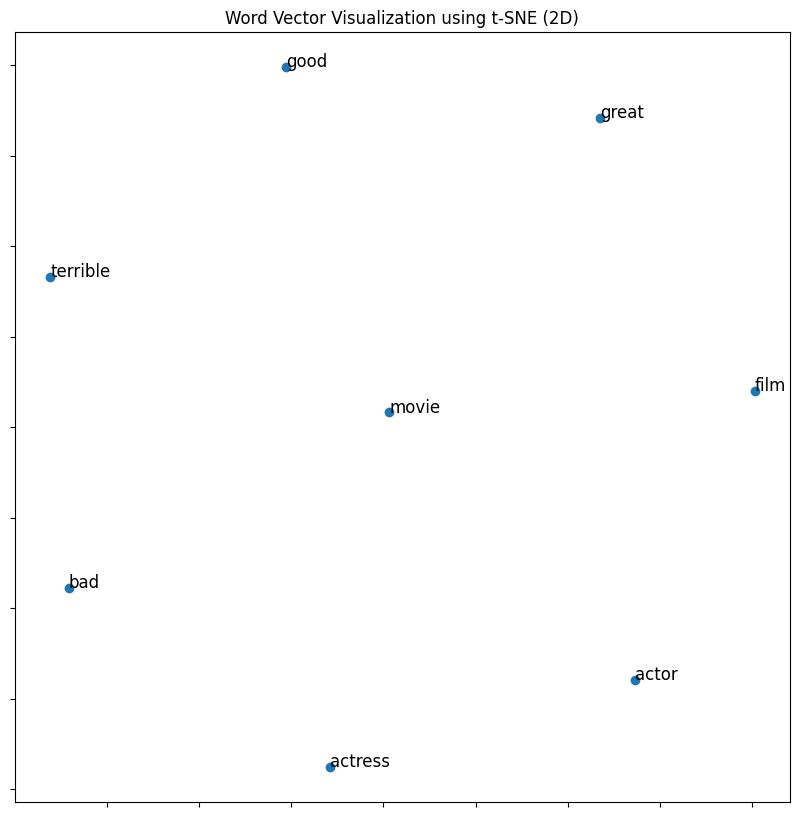


Top 5 words similar to ['good']:
cindy: 0.3899
unknown: 0.3827
gandhis: 0.3755
despairbr: 0.3739
specimen: 0.3646

Top 5 words similar to ['bad']:
parole: 0.3785
artisans: 0.3751
patrons: 0.3634
patten: 0.3588
mettle: 0.3563

Top 5 words similar to ['movie', 'film']:
unafraid: 0.4219
coax: 0.3810
fells: 0.3693
bids: 0.3601
loveless: 0.3570


In [10]:
import re
from sklearn.datasets import load_files
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

# Import gensim
from gensim.models import Word2Vec


def preprocess_text(text):
    """
    Preprocesses the input text by removing special characters, URLs,
    lowercasing, and tokenizing it.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    
    # Remove special characters 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    
    # Lowercase the text
    text = text.lower()
    
    # Tokenize the text
    tokens = text.split()
    
    return tokens

def load_and_preprocess_imdb(data_dir):
    """
    Loads the IMDB dataset from the specified directory and preprocesses
    the text data.
    """
    review_data = load_files(data_dir, encoding='utf-8')
    preprocessed_reviews = [preprocess_text(review) for review in review_data.data]
    return preprocessed_reviews, review_data.target

def visualize_word_vectors(model, words_to_visualize=None, n_components=2):
    """
    Visualizes word vectors using t-SNE.

    Args:
        model: A trained Gensim Word2Vec model.
        words_to_visualize:  A list of words to visualize. If None, visualize top occurring words.
        n_components: The number of dimensions of the embedded space.
    """
    
    if words_to_visualize is None:
        words_to_visualize = [word for word, _ in model.wv.most_common(50)]  
    
    # Filter words that exist in the model's vocabulary
    words_to_visualize = [word for word in words_to_visualize if word in model.wv]
        
    if not words_to_visualize:
        print("No words to visualize.  Check the vocabulary of the model and the words provided.")
        return
        

    vectors = np.array([model.wv[word] for word in words_to_visualize])
    
    if vectors.shape[0] < 2:
        print("Need at least two words to visualize.")
        return

    # 
    perplexity = min(30, vectors.shape[0] - 1) 
    tsne_model = TSNE(perplexity=perplexity, n_components=n_components, init='pca', n_iter=5000, random_state=23)
    vectors_tsne = tsne_model.fit_transform(vectors)

    fig, ax = plt.subplots(figsize=(10, 10))  
    ax.scatter(vectors_tsne[:, 0], vectors_tsne[:, 1])
    for i, word in enumerate(words_to_visualize):
        ax.annotate(word, xy=(vectors_tsne[i, 0], vectors_tsne[i, 1]), fontsize=12)  
    
    if n_components == 2:
        ax.set_yticklabels([])
        ax.set_xticklabels([])
    plt.title(f'Word Vector Visualization using t-SNE ({n_components}D)')
    plt.show()

def find_similar_words(model, positive_words, topn=5):
    """
    Finds and prints the most similar words to the given words using the Word2Vec model.

    Args:
        model: A trained Gensim Word2Vec model.
        positive_words: A list of words to find similar words to.
        topn: The number of similar words to return.
    """
    try:
        similar_words = model.wv.most_similar(positive=positive_words, topn=topn)
        print(f"\nTop {topn} words similar to {positive_words}:")
        for word, similarity in similar_words:
            print(f"{word}: {similarity:.4f}")
    except KeyError as e:
        print(f"\nWord(s) {positive_words} not found in the vocabulary: {e}")
    except AttributeError:
        print("\nModel does not have the attribute 'wv'.  Ensure it is a trained Word2Vec model.")

if __name__ == "__main__":
    # Load and preprocess the IMDB training data
    train_dir = './aclImdb/train'
    preprocessed_train_reviews, y_train = load_and_preprocess_imdb(train_dir)

    # Train Word2Vec model
    vector_size = 100
    window_size = 5
    min_count = 5
    epochs = 10

    model = Word2Vec(sentences=preprocessed_train_reviews,
                     vector_size=vector_size,
                     window=window_size,
                     min_count=min_count,
                     epochs=epochs,
                     workers=-1)

    # Save the trained model
    model.save("word2vec_imdb.model")
    print("\nWord2Vec model trained and saved as 'word2vec_imdb.model'")
    
    # Visualize word vectors
    visualize_word_vectors(model, words_to_visualize=['good', 'bad', 'movie', 'film', 'great', 'terrible', 'actor', 'actress'], n_components=2)
    
    # Find similar words
    find_similar_words(model, positive_words=['good'], topn=5)
    find_similar_words(model, positive_words=['bad'], topn=5)
    find_similar_words(model, positive_words=['movie', 'film'], topn=5)



In [11]:
import re
import numpy as np
from sklearn.datasets import load_files
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from gensim.models import KeyedVectors


def preprocess_text(text):
    """
    Preprocesses the input text by removing special characters, URLs,
    lowercasing, and tokenizing it.
    """
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)
    # Remove special characters 
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    # Lowercase the text
    text = text.lower()
    # Tokenize the text
    tokens = text.split()
    return tokens


def load_and_preprocess_imdb(data_dir):
    """
    Loads the IMDB dataset from the specified directory and preprocesses
    the text data.
    """
    review_data = load_files(data_dir, encoding='utf-8')
    preprocessed_reviews = [preprocess_text(review) for review in review_data.data]
    return preprocessed_reviews, review_data.target


def get_word_vectors(model, preprocessed_reviews, vector_size):
    """
    Get word vectors for each review in the dataset.  Averages the word vectors for each review.

    Args:
        model: A trained Gensim Word2Vec model (or KeyedVectors).
        preprocessed_reviews: A list of preprocessed movie reviews (list of lists of tokens).
        vector_size: The dimensionality of the word vectors.

    Returns:
        A numpy array of shape (num_reviews, vector_size) containing the averaged word vectors for each review.
    """
    review_vectors = []
    for review in preprocessed_reviews:
        word_vectors = []
        for word in review:
            try:
                word_vector = model[word] 
                word_vectors.append(word_vector)
            except KeyError:
                # Word not in vocabulary, skip it
                pass
        if word_vectors:
            # Average the word vectors for the review
            review_vector = np.mean(word_vectors, axis=0)
        else:
            #
            review_vector = np.zeros(vector_size)
        review_vectors.append(review_vector)
    return np.array(review_vectors)



def train_and_evaluate_classifier(X_train, y_train, X_test, y_test, model_name="Logistic Regression"):
    """
    Trains a Logistic Regression classifier on the given data and evaluates its performance.

    Args:
        X_train: Training data features.
        y_train: Training data labels.
        X_test: Test data features.
        y_test: Test data labels.
        model_name:  Name of the model for reporting
    """
    # Train a Logistic Regression classifier
    classifier = LogisticRegression(solver='liblinear', random_state=42, max_iter=500)  # Increased max_iter
    classifier.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = classifier.predict(X_test)

    # Evaluate the classifier
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred)

    print(f"\n--- {model_name} ---")
    print(f"Accuracy: {accuracy:.4f}")
    print("Classification Report:\n", report)

if __name__ == "__main__":
    # Load and preprocess the IMDB data
    train_dir = './aclImdb/train'
    test_dir = './aclImdb/test'
    preprocessed_train_reviews, y_train = load_and_preprocess_imdb(train_dir)
    preprocessed_test_reviews, y_test = load_and_preprocess_imdb(test_dir)

    # --- 1. Using Word2Vec trained on IMDB ---
    print("--- 1. Using Word2Vec trained on IMDB ---")
    # Train Word2Vec model on the IMDB training data
    vector_size = 100
    word2vec_model = Word2Vec(sentences=preprocessed_train_reviews,
                                 vector_size=vector_size,
                                 window=5,
                                 min_count=5,
                                 epochs=10,
                                 workers=-1)

    # Get Word2Vec vectors for the training and test sets
    X_train_word2vec = get_word_vectors(word2vec_model.wv, preprocessed_train_reviews, vector_size)
    X_test_word2vec = get_word_vectors(word2vec_model.wv, preprocessed_train_reviews, vector_size)

    # Train and evaluate a classifier using the Word2Vec vectors
    train_and_evaluate_classifier(X_train_word2vec, y_train, X_test_word2vec, y_test, model_name="Logistic Regression (Word2Vec - IMDB)")


    # --- 2. Using pre-trained GloVe embeddings ---
    print("\n--- 2. Using pre-trained GloVe embeddings ---")
    # Load pre-trained GloVe vectors (download if needed)
    glove_file = r"C:\Users\Admin\Downloads\glove.6B\glove.6B.100d.txt"
    glove_model = None # Initialize glove_model
    try:
        glove_model = KeyedVectors.load_word2vec_format(glove_file, binary=False, no_header=True)
        print(f"Loaded pre-trained GloVe vectors from {glove_file}")
    except FileNotFoundError:
        print(f"Error: GloVe file '{glove_file}' not found. ")
        

    # Get GloVe vectors for the training and test sets
    if glove_model: 
        X_train_glove = get_word_vectors(glove_model, preprocessed_train_reviews, vector_size)
        X_test_glove = get_word_vectors(glove_model, preprocessed_test_reviews, vector_size)

        # Train and evaluate a classifier using the GloVe vectors
        train_and_evaluate_classifier(X_train_glove, y_train, X_test_glove, y_test, model_name="Logistic Regression (GloVe)")
    else:
        print("GloVe model was not loaded, skipping GloVe training and evaluation.")


--- 1. Using Word2Vec trained on IMDB ---

--- Logistic Regression (Word2Vec - IMDB) ---
Accuracy: 0.6471
Classification Report:
               precision    recall  f1-score   support

           0       0.65      0.63      0.64     12500
           1       0.64      0.66      0.65     12500

    accuracy                           0.65     25000
   macro avg       0.65      0.65      0.65     25000
weighted avg       0.65      0.65      0.65     25000


--- 2. Using pre-trained GloVe embeddings ---
Loaded pre-trained GloVe vectors from C:\Users\Admin\Downloads\glove.6B\glove.6B.100d.txt

--- Logistic Regression (GloVe) ---
Accuracy: 0.7972
Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.81      0.80     12500
           1       0.80      0.79      0.79     12500

    accuracy                           0.80     25000
   macro avg       0.80      0.80      0.80     25000
weighted avg       0.80      0.80      0.80     25000

